# Bibliotecas necesarias
---

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pd;
import unittest
import matplotlib.pyplot as plt
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal

# Implementación del perceptrón multicapa
---


### Funciones de activación


In [ ]:
def calculate_sigmoid(p):
    return 1 / (1 + torch.exp(-p))


def calculate_tanh(p):
    return (torch.exp(p) - torch.exp(-p)) / (torch.exp(p) + torch.exp(-p))


def calculate_softmax(p, dim=0):
    """
    Resta el máximo para estabilidad numérica, aplica el exponencial a los elementos de la matriz.
    Suma de la matriz de entrada en la dimensión especificada
    Se divide los exponenciales entre la suma de la matriz
    """
    p = p - torch.max(p)
    exps = torch.exp(p)
    sum_exps = torch.sum(exps, dim=dim, keepdim=True)
    return exps / sum_exps

### Definición de clase

In [ ]:
class Multi_layer_perceptron():
    """
    Implementación de una red neuronal multicapa (MLP).

    Esta clase proporciona métodos para la creación, entrenamiento y evaluación de una MLP
    con una arquitectura configurable. Utiliza funciones de activación tangente hiperbólica
    y emplea el algoritmo de retropropagación para el entrenamiento.

    Parámetros:
    - neurons_per_layer: Lista que contiene el número de neuronas para cada capa.
    - alpha: Tasa de aprendizaje.
    - gamma: Tasa de momentum.
    - max_weights: Valor máximo absoluto de los pesos de la red.
    - device: Dispositivo de cómputo (por defecto, 'cpu').
    """
    def __init__(self, neurons_per_layer, alpha = 0.01, gamma = 0.9, max_weights = 1, device = "cpu"):
        """
        Inicializa una red neuronal multicapa.

        :param neurons_per_layer: Lista que contiene el número de neuronas para cada capa.
        :param alpha: Tasa de aprendizaje.
        :param gamma: Tasa de momentum.
        :param max_weights: Valor máximo absoluto de los pesos de la red.
        :param device: Dispositivo de cómputo (por defecto, 'cpu').
        """
        self.neurons_per_layer = neurons_per_layer
        self.D, self.M, self.K = neurons_per_layer

        # Neuronas de sesgo
        self.D += 1
        self.M += 1

        self.alpha = alpha
        self.gamma = gamma
        self.max_weights = max_weights

        torch.manual_seed(11)
        # Inicialización de pesos de forma aleatoria dentro del rango permitido
        self.W_o = (torch.rand(self.D, self.M) * 2) - 1
        self.W_o = torch.min(self.W_o, torch.tensor(max_weights))

        self.W_s = (torch.rand(self.M, self.K) * 2) - 1
        self.W_s = torch.min(self.W_s, torch.tensor(max_weights))
        # self.W_o = torch.empty(self.D, self.M, device=device)
        # self.W_s = torch.empty(self.M, self.K, device=device)
        # init.xavier_uniform_(self.W_o)
        # init.xavier_uniform_(self.W_s)

        # # Clip de los pesos para asegurar que no excedan el valor máximo
        # self.W_o = torch.clamp(self.W_o, min=-max_weights, max=max_weights)
        # self.W_s = torch.clamp(self.W_s, min=-max_weights, max=max_weights)

        # Colocamos la neurona de sesgos en la capa oculta
        self.W_o[:, 0] = torch.nan

        # Inicialización de los valores de los deltas (δ)
        self.delta_o = None
        self.delta_s = None

        # Inicialización de los P
        self.P_o = None
        self.P_s = None

        # Inicialización de las salidas de las capas
        self.Y_o = None
        self.Y_s = None

        # Inicialización de los valores de momentum para cada conjunto de pesos
        self.momentum_W_o = torch.zeros_like(self.W_o)
        self.momentum_W_s = torch.zeros_like(self.W_s)


    def forward(self, X):
        """
        Evaluacion de la pasada hacia adelante de la red con X (nxd) los datos de entrada
        :param X: Matriz con la muestra de entradas, n observaciones de d dimensiones
        return: un arreglo con la salida de la red neuronal en todas sus neuronas de salida
        """
        # Calcular la salida de la capa oculta
        self.P_o = X.mm(self.W_o)
        self.Y_o = calculate_tanh(self.P_o)

        # Replace nan values with 1's
        tmpY_o = self.Y_o
        tmpY_o[torch.isnan(tmpY_o)] = 1.

        # Calcular la salida de la capa de salida
        self.P_s = tmpY_o.mm(self.W_s)
        self.Y_s = calculate_tanh(self.P_s)

        # Retornar la salida de la capa de salida
        return self.Y_s


    def get_error(self, Y_s, T):
        """
        Calcula el error medio cuadrático para un conjunto de salidas y objetivos.

        :param Y_s: Tensor de salidas de la red neuronal.
        :param T: Tensor de objetivos (en notación one-hot vector).
        :return: Error medio cuadrático.
        """
        # Calcular el error utilizando la función de error E(w)
        error = torch.sum(torch.norm(Y_s - T, p=2, dim=1)**2) * (1 / Y_s.shape[0])
        return error.item()


    def backpropagate_deltas(self, X, T):
        """
        Calcula los deltas de error para las capas oculta y de salida.

        :param X: Tensor de entrada.
        :param T: Tensor de objetivos.
        """
        # Calcular los deltas de la capa de salida
        self.delta_s = (2 * (self.Y_s - T)) * (1 - (self.Y_s**2))

        # Calcular los deltas de la capa oculta
        self.delta_o = self.delta_s.mm(self.W_s.t()) * (1 - (self.Y_o**2))
        return


    def update_weights(self, X, T):
        """
        Actualiza los pesos de la red neuronal.

        :param X: Tensor de entrada.
        :param T: Tensor de objetivos.
        """
        # Calcular los gradientes para los pesos
        dW_o = X.t().mm(self.delta_o)
        dW_s = self.Y_o.t().mm(self.delta_s)

        # Aplicar momentum
        self.momentum_W_o = self.gamma * self.momentum_W_o + self.alpha * dW_o
        self.momentum_W_s = self.gamma * self.momentum_W_s + self.alpha * dW_s

        # Actualizar los pesos
        self.W_o -= self.momentum_W_o
        self.W_s -= self.momentum_W_s
        return


    def addones(self, tensor):
        # crear columna de 1s con el tamaño correspondiente al tensor
        ones_col = torch.ones(tensor.shape[0], 1)
        # concatenar la columna de 1s al tensor
        return torch.cat((ones_col, tensor), dim=1)


    def train_mlp(self, num_epochs, X, T, alpha, gamma, X_test=None, T_test=None, print_e=True):
        """
        Entrena la red neuronal durante un número dado de épocas.

        :param num_epochs: Número de épocas de entrenamiento.
        :param X: Tensor de entrenamiento.
        :param T: Tensor de objetivos para el entrenamiento.
        :param alpha: Tasa de aprendizaje.
        :param gamma: Tasa de momentum.
        :param X_test: Tensor de prueba (opcional).
        :param T_test: Tensor de objetivos para la prueba (opcional).
        :return: Lista de errores de entrenamiento, lista de errores de prueba (si se proporcionan), y época de convergencia.
        """
        # Inicializar la red neuronal
        self.alpha = alpha
        self.gamma = gamma

        # Agregar columna de 1s a las entradas
        X = self.addones(X)

        # Agrear columna de 1s si los tests no son None
        if X_test is not None:
            X_test = self.addones(X_test)

        # Almacenar los errores de entrenamiento en cada época
        errors = []
        errors_test = []
        epoch_converge = None

        # Ciclo de entrenamiento
        for epoch in range(num_epochs):
            # Calcular la salida de la capa oculta con los datos de entrenamiento
            self.forward(X)

            # Aplicar el backpropagation para los datos de entrenamiento
            self.backpropagate_deltas(X, T)

            # Actualizar los pesos de la red neuronal para cada muestra de entrenamiento
            self.update_weights(X, T)

            # Calcular el error medio cuadrático y añadirlo a la lista de errores para los datos de entrenamiento
            error = self.get_error(self.Y_s, T)
            errors.append(error)

            # Ajustar las salidas Y_s a 1 o -1 utilizando torch.where
            adjusted_Y_s = torch.where(self.Y_s > 0.9, torch.tensor(1.), torch.where(self.Y_s < -0.9, torch.tensor(-1.), self.Y_s))

            # Verificar si las salidas ajustadas son iguales a los objetivos T
            if epoch_converge is None and torch.equal(adjusted_Y_s, T):
                print(f"Red converge en {epoch} con un error de {error}, el Y_s ajustado es \n{adjusted_Y_s}")
                epoch_converge = epoch

            # Imprimir el progreso cada cierto número de épocas
            if epoch % (num_epochs/100) == 0 and print_e:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {error}')

            # Obtener la salida con datos de prueba
            if X_test is not None and T_test is not None:
                error_test = self.trainTest(X_test, T_test)
                errors_test.append(error_test)

        if X_test is not None and T_test is not None:
            return errors, errors_test, epoch_converge

        return errors, epoch_converge


    def trainTest(self, X_test, T_test):
        """
        Calcula el error para un conjunto de datos de prueba.

        :param X_test: Tensor de datos de prueba.
        :param T_test: Tensor de objetivos para los datos de prueba.
        :return: Error para los datos de prueba.
        """
        # Calcular la salida de la capa oculta con las entradas de prueba
        Y_sTest = self.forward(X_test)
        error = self.get_error(Y_sTest, T_test)
        return error

### Pruebas unitarias

In [ ]:
def print_tests(name, inputs, expected, output):
    print(f'[TEST][{name}]')
    print("- inputs:  ", inputs)
    print("- expected:", expected)
    print("- output: ", output, "\n")

In [ ]:
class TestActivationFunctions(unittest.TestCase):
    def test_sigmoid(self):
        inputs = torch.tensor([-1.0, 0.0, 1.0])
        expected_outputs = torch.sigmoid(inputs)
        outputs = calculate_sigmoid(inputs)
        torch.testing.assert_close(outputs, expected_outputs)
        print_tests("SIGMOID", inputs, expected_outputs, outputs)

    def test_tanh(self):
        inputs = torch.tensor([-1.0, 0.0, 1.0])
        expected_outputs = torch.tanh(inputs)
        outputs = calculate_tanh(inputs)
        torch.testing.assert_close(outputs, expected_outputs)
        print_tests("TANH", inputs, expected_outputs, outputs)


    def test_softmax(self):
        inputs = torch.tensor([1.0, 2.0, 3.0])
        expected_outputs = torch.softmax(inputs, dim=0)
        outputs = calculate_softmax(inputs)
        torch.testing.assert_close(outputs, expected_outputs)
        print_tests("SOFTMAX", inputs, expected_outputs, outputs)


In [ ]:
class TestMultiLayerPerceptron(unittest.TestCase):
    def print_attributes(self, name):
        print(f'[TestMultiLayerPerceptron | {name}]')
        for attribute, value in self.MLP.__dict__.items():
            print(f"{attribute}: {value}")

    def init_mlp(self):
        neurons_per_layer = (3, 3, 2)
        max = 0.5
        self.MLP = Multi_layer_perceptron(neurons_per_layer, max_weights=max, device="cpu")


    def test_mlp_init(self):
        # Configuración de prueba
        self.init_mlp()
        mlp = self.MLP

        # Verificamos que los pesos no excedan el valor máximo
        no_bias = mlp.W_o[:,1:]
        self.assertTrue(torch.all(no_bias <= mlp.max_weights) and (torch.all(no_bias >= -mlp.max_weights)))
        self.assertTrue(torch.all(mlp.W_s <= mlp.max_weights) and (torch.all(mlp.W_s >= -mlp.max_weights)))

        # Comprobamos si la primera columna de W_o, correspondiente al sesgo, es NaN
        self.assertTrue(torch.all(torch.isnan(mlp.W_o[:, 0])))

        # Valdar las dimensiones correctas
        self.assertTrue(mlp.W_o.shape == (mlp.D, mlp.M))
        self.assertTrue(mlp.W_s.shape == (mlp.M, mlp.K))
        self.print_attributes(self.test_mlp_init.__name__)


    def test_forward_output(self):
        # Configuración de prueba
        self.init_mlp()
        mlp = self.MLP

        # Datos de entrada simulados
        N, D = 5, 3
        X = torch.randn(N, D)

        # Agregar una columna de 1's a la entrada
        ones_column = torch.ones((X.shape[0], 1))
        X = torch.cat((ones_column, X), 1)

        # Ejecutar la propagración hacia adelnate
        output = mlp.forward(X)

        # Comprobar dimensiones correctas (6, 3)
        self.assertEqual(output.shape, (N, mlp.K))

        # No debería haber NaNs en la salida
        self.assertFalse(torch.isnan(output).any())

        # Verificar que los valores estén en el rango de la función tanh (-1 a 1)
        self.assertTrue(torch.all(output >= -1) and torch.all(output <= 1))
        self.print_attributes(self.test_forward_output.__name__)

In [ ]:
# suite = TestActivationFunctions
suite = TestMultiLayerPerceptron

# Crear la instancia del test suite
test_suite = unittest.TestSuite()
test_suite.addTest(unittest.makeSuite(suite))

# Ejecutar las pruebas
runner = unittest.TextTestRunner()
runner.run(test_suite)

.F
FAIL: test_mlp_init (__main__.TestMultiLayerPerceptron)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-6-7d3042e5c4c8>", line 20, in test_mlp_init
    self.assertTrue(torch.all(no_bias <= mlp.max_weights) and (torch.all(no_bias >= -mlp.max_weights)))
AssertionError: tensor(False) is not true

----------------------------------------------------------------------
Ran 2 tests in 0.315s

FAILED (failures=1)


[TestMultiLayerPerceptron | test_forward_output]
neurons_per_layer: (3, 3, 2)
D: 4
M: 4
K: 2
alpha: 0.01
gamma: 0.9
max_weights: 0.5
W_o: tensor([[    nan, -0.0269,  0.5000, -0.6632],
        [    nan,  0.3872,  0.1662, -0.7431],
        [    nan,  0.5000, -0.4613,  0.5000],
        [    nan, -0.0735,  0.5000,  0.0049]])
W_s: tensor([[-0.7950,  0.5000],
        [ 0.5000,  0.5000],
        [ 0.5000,  0.4461],
        [ 0.5000,  0.1640]])
delta_o: None
delta_s: None
P_o: tensor([[    nan, -0.6654,  1.0377, -1.0239],
        [    nan,  0.2187,  0.2806, -0.5580],
        [    nan,  0.1807,  0.1505, -1.5783],
        [    nan,  0.8612, -0.5911, -1.2875],
        [    nan, -1.3931,  0.8025, -1.0158]])
P_s: tensor([[-1.0832,  0.4291],
        [-0.8039,  0.6465],
        [-1.0901,  0.5054],
        [-1.1411,  0.4709],
        [-1.2883,  0.2289]])
Y_o: tensor([[ 1.0000, -0.5819,  0.7770, -0.7715],
        [ 1.0000,  0.2152,  0.2735, -0.5065],
        [ 1.0000,  0.1788,  0.1493, -0.9183],
      

<unittest.runner.TextTestResult run=2 errors=0 failures=1>

# Clasificador de función XOR
---

In [ ]:
import os
import shutil


def create_XOR_model():
    """
    Crea un modelo MLP específico para resolver el problema del XOR.

    Returns:
    - mlp: Instancia de la clase Multi_layer_perceptron con la arquitectura definida.
    """
    # Se define una arquitectura de 2 neuronas de entrada, 2 en la capa oculta y 1 en la capa de salida
    mlp = Multi_layer_perceptron(neurons_per_layer=[2, 2, 1])
    return mlp


# Entrenador del XOR para los parámetros provistos
def trainXOR(XOR_model, alpha, gamma, epochs, directory):
    """
    Entrena el modelo XOR con los parámetros especificados.

    Parameters:
    - XOR_model: Modelo MLP para entrenar.
    - alpha: Tasa de aprendizaje.
    - gamma: Tasa de momentum.
    - epochs: Número de épocas de entrenamiento.
    - directory: Directorio donde se guardarán las gráficas de entrenamiento.

    Returns:
    - Converge: Valor booleano que indica si la red converge durante el entrenamiento.
    """
    # Entradas del modelo (tabla de verdad del XOR)
    X = torch.tensor([
        [0, 0.],
        [0, 1],
        [1, 0],
        [1, 1]
    ])

    # Salidas esperadas (tabla de verdad del XOR)
    # Se cambian los 0 por -1 por el uso de la función tanh(X)
    T = torch.tensor([
        [-1.],
        [1.],
        [1.],
        [-1.]
    ])

    # Entrenamiento de la red neuronal con la configuración actual de hiperparámetros
    # Se recibe los errores y la época donde converge la red
    errors, epoch_converge = XOR_model.train_mlp(epochs, X, T, alpha=alpha, gamma=gamma)

    plot_XOR(XOR_model, errors, epoch_converge, alpha, gamma, epochs, directory)

    # Retorna True si la red converge, False de lo contrario
    if epoch_converge is None:
        return False
    return True


def plot_XOR(XOR_model, errors, epoch_converge, alpha, gamma, epochs, directory):
    """
    Visualiza los resultados del entrenamiento del modelo XOR.

    Parameters:
    - XOR_model: Modelo MLP entrenado.
    - errors: Lista de errores durante el entrenamiento.
    - epoch_converge: Época en la que la red converge.
    - alpha: Tasa de aprendizaje utilizada en el entrenamiento.
    - gamma: Tasa de momentum utilizada en el entrenamiento.
    - epochs: Número total de épocas de entrenamiento.
    - directory: Directorio donde se guardarán las gráficas generadas.
    """

    # Obtenemos el resultado (Y_s) y vemos si es un resultado cercano a las salidas esperadas
    predicted = torch.where(XOR_model.Y_s > 0.9, torch.tensor(1.), torch.where(XOR_model.Y_s < -0.9, torch.tensor(-1.), XOR_model.Y_s))
    print("Salida del modelo XOR sin procesar\n", XOR_model.Y_s)
    print("Salida del modelo XOR procesada\n", predicted)

    # Se imprime los parámetros usados, los errores y la época donde la red converge
    print(f"Configuración de hiperparámetros: alpha {alpha}, gamma {gamma}, épocas {epochs}")
    print("Errores:", errors)
    print("Red converge en ", epoch_converge)

    # Si la red converge, se guardan las gráficas
    if epoch_converge is not None:
        # Crear un gráfico para visualizar la curva de aprendizaje
        #plt.figure(figsize=(10, 6))  # Tamaño del gráfico
        plt.plot(range(len(errors)), errors, color='blue', linewidth=1, marker='.', markersize=1.5)  # Graficar los errores
        plt.xlabel('Época')  # Etiqueta del eje x
        plt.ylabel('Error en la época')  # Etiqueta del eje y
        plt.title(f'Curva de aprendizaje para la configuración de \nhiperparámetros alpha={alpha}, gamma={gamma}, épocas={epochs}')  # Título del gráfico
        plt.grid(True)  # Activar la cuadrícula
        plt.tight_layout()  # Ajustar el espacio de la figura
        plt.savefig(f'{directory}curva_aprendizaje_alpha_{alpha}_gamma_{gamma}_epochs_{epochs}.png', dpi=300)
        plt.show()  # Mostrar el gráfico

        # Gráfico para visualizar la convergencia de la red
        #plt.figure(figsize=(10, 6))  # Tamaño del gráfico
        plt.plot(range(len(errors)), errors)
        plt.xlabel('Época')
        plt.ylabel('Error en la época')
        plt.title(f'Convergencia de la red para la configuración de \nhiperparámetros alpha={alpha}, gamma={gamma}, épocas={epochs}')
        plt.axvline(x=epoch_converge, color='r', linestyle='--', label=f'Convergencia en {epoch_converge} épocas')
        plt.legend()
        plt.tight_layout()  # Ajustar el espacio de la figura
        plt.savefig(f'{directory}convergencia_alpha_{alpha}_gamma_{gamma}_epochs_{epochs}.png', dpi=300)
        plt.show()

# Definir diferentes valores para los hiperparámetros a probar
epochs = [100, 150, 75, 200, 50]
alphas = [0.004, 0.05, 0.6, 0.01, 0.1]
gammas = [0.0001, 0.3, 0.08, 0.7, 0.9]

# Nombre del directorio donde se guardarán las imágenes
# /content/drive/MyDrive/Computación/2024/IS/IA/TP1/
directory = '/content/resultados/'

# Si el directorio existe, elimina su contenido
if os.path.exists(directory):
    shutil.rmtree(directory)

# Crea el directorio para guardar las imágenes
os.makedirs(directory)

# Hashmap para almacenar las configuraciones de hiperparámetros que convergen
converged_configurations = {}

# Selección de la combinación de hiperparámetros
for alpha in alphas:
    for gamma in gammas:
        for epochs_value in epochs:
            # Obtener modelo para entrenar XOR
            xorMlp = create_XOR_model()
            if trainXOR(xorMlp, alpha, gamma, epochs_value, directory):
                # Almacenar la configuración que converge en el hashmap
                converged_configurations[(alpha, gamma, epochs_value)] = "Converge"
            else:
                converged_configurations[(alpha, gamma, epochs_value)] = "No converge"

# Imprimir el hashmap en formato de tabla LaTeX
print("\\begin{table}[htbp]")
print("\\centering")
print("\\begin{tabular}{|c|c|c|c|}")
print("\\hline")
print("Alpha & Gamma & Epochs & Converge \\\\")
print("\\hline")
for key, value in converged_configurations.items():
    print(f"{key[0]} & {key[1]} & {key[2]} & {value} \\\\")
print("\\hline")
print("\\end{tabular}")
print("\\caption{Convergencia de las configuraciones de hiperparámetros}")
print("\\label{tab:convergencia-hiperparametros}")
print("\\end{table}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Clasificador de datos $\mathbb{R}^{2}$
---

## Creación de datos

In [ ]:
def create_data(number_observations_per_class = 5, mean1 = [2, 2], mean2 = [26, 26], stds1 = [3, 3], stds2 = [2, 1], device = "cpu", title = ""):
    """
    Creates the data to be used for training, using a GMM distribution
    @param number_observations_per_class, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(number_observations_per_class, 1, device = device)
    means[0] = mean1[0]
    means[1] = mean1[1]

    # Covariance matrix creation with identity
    covariance_matrix = torch.eye(2)
    covariance_matrix[0, 0] = stds1[0]
    covariance_matrix[1, 1] = stds1[1]
    sample_class1 = createDataOneClass(means, covariance_matrix, number_observations_per_class)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covariance_matrix[0, 0] = stds2[0]
    covariance_matrix[1, 1] = stds2[1]
    sample_class2 = createDataOneClass(means, covariance_matrix, number_observations_per_class)

    # Concatenates the ones for the bias
    sample_class1Bias = torch.cat((ones, sample_class1), 1)
    sample_class2Bias = torch.cat((ones, sample_class2), 1)
    samplesAll = torch.cat((sample_class1, sample_class2), 0)
    plt.figure(figsize=(6, 4))
    plt.scatter(sample_class1[:, 0], sample_class1[:, 1], color='red', label='Clase 1', marker="x")
    plt.scatter(sample_class2[:, 0], sample_class2[:, 1], color='blue', label='Clase 2')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

    #Create samples with bias
    samplesAllBias = torch.cat((sample_class1Bias, sample_class2Bias), 0)

    #Create targets
    targets_class1 = torch.ones(number_observations_per_class, 1, device = device)
    targets_class2 = torch.zeros(number_observations_per_class, 1, device = device)
    targetsAll = torch.cat((targets_class1, targets_class2), 0)

    return (targetsAll, samplesAllBias)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covariance_matrix, numberSamples, device = "cpu"):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covariance_matrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    samples = samples.clone().detach()
    return samples

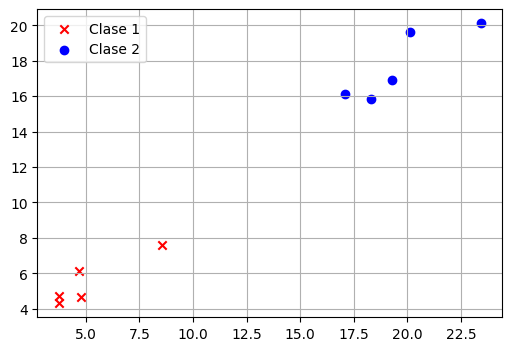

SamplesAll 
 tensor([[ 1.0000,  4.6989,  6.1103],
        [ 1.0000,  8.5706,  7.6014],
        [ 1.0000,  3.7380,  4.3065],
        [ 1.0000,  3.7335,  4.7175],
        [ 1.0000,  4.7757,  4.6870],
        [ 1.0000, 23.4535, 20.1157],
        [ 1.0000, 20.1402, 19.6149],
        [ 1.0000, 19.2737, 16.8925],
        [ 1.0000, 17.1013, 16.1236],
        [ 1.0000, 18.2937, 15.8472]])


In [ ]:
def test_create_data():
    (TargetsAll, SamplesAll) = create_data(number_observations_per_class = 5, mean1 = [5, 5], mean2 = [18, 18], stds1 = [5, 2], stds2 = [12, 2], device = "cpu")
    print("SamplesAll \n", SamplesAll)
    return TargetsAll, SamplesAll

y, X = test_create_data()

## Generar dos conjuntos de datos. *(uno linealmente separable y otro no linealmente separable)*

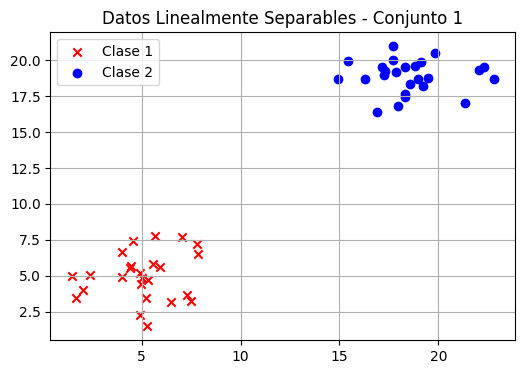

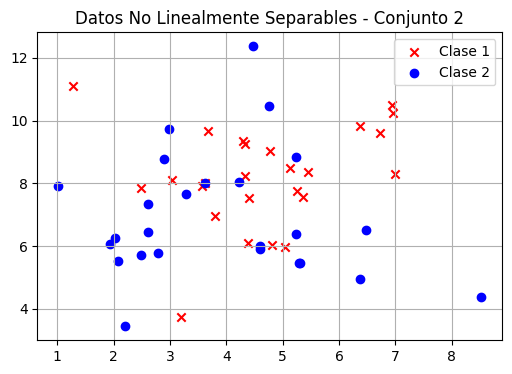

In [ ]:
def generate_datasets():
    # Crear datos R^2 linealmente separables
    (T1, X1) = create_data(number_observations_per_class = 25,
                           mean1 = [5, 5], mean2 = [19, 19],
                           stds1 = [5, 2], stds2 = [5, 2],
                           device = "cpu",
                           title = 'Datos Linealmente Separables - Conjunto 1'
                )

    # Crear datos R^2 no linealmente separables
    (T2, X2) = create_data(number_observations_per_class = 25,
                           mean1 = [5, 8], mean2 = [4, 7],
                           stds1 = [2, 3], stds2 = [2, 5],
                           device = "cpu",
                           title = 'Datos No Linealmente Separables - Conjunto 2'
                )

    return (T1, X1), (T2, X2)

(T1, X1), (T2, X2) = generate_datasets()
# Remover columna de 1s autogenerada en X1 y X2
X1_r2 = X1[:, 1:]
X2_r2 = X2[:, 1:]
T1_r2 = T1
T2_r2 = T2

## Entrenador para ambos conjuntos en $\mathbb{R}^{2}$



### Graficación de resultados

In [ ]:
def log_data(mlpTrain, errorsTrain, epoch_convergeTrain, tipo):
    # Se imprime los parámetros usados, los errores y la época donde la red converge
    print("Tipo:", tipo)
    print(f"Configuración de hiperparámetros: Neuronas {[mlpTrain.D, mlpTrain.M, mlpTrain.K]}, alpha {mlpTrain.alpha}, gamma {mlpTrain.gamma}")
    print("Errores:", errorsTrain)
    print("Error mínimo:", min(errorsTrain))
    print("Red converge en ", epoch_convergeTrain, "\n\n")


def graphic_errors(errorsTrain, errorsTest, epoch_convergeTrain, tipo, mlp):
    # Tamaño del gráfico
    plt.figure(figsize=(10, 6))

    # Datos de entrenamiento
    plt.plot(range(len(errorsTrain)), errorsTrain, color='green', linewidth=2, marker='.', markersize=4, label='Entrenamiento')

    # Datos de prueba
    plt.plot(range(len(errorsTest)), errorsTest, color='blue', linewidth=2, marker='.', markersize=4, label='Evaluación del Error')

    # Etiquetas
    plt.xlabel('Época', fontsize=14)
    plt.ylabel('Error en la época', fontsize=14)
    plt.title(f'Datos en $R^2$: Función de iteraciones y error para datos {tipo}\n con $\\alpha = {mlp.alpha}$, $\\gamma = {mlp.gamma}$', fontsize=16)
    if epoch_convergeTrain is not None:
        plt.axvline(x=epoch_convergeTrain, color='orange', linestyle='--', label=f'Convergencia en {epoch_convergeTrain} épocas (Entrenamiento)')
    else:
        plt.axvline(x=50, color='r', linestyle='--', label=f'Modelo no converge (Entrenamiento)')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

### Construir las 4 arquitecturas de redes neuronales
Las 4 arquitecturas se definen a continuación, donde todas tienen D=2 neuronas de entradas y K=1 neuronas en la capa de salida:

| Arquitectura | M (Neuronas en capa oculta) | Alpha | Gamma |
|--------------|------------------------------|-------|-------|
| Primera      | 25                           | 0.005 | 0.7   |
| Segunda      | 25                           | 0.03  | 0     |
| Tercera     | 4                            | 0.1   | 0.0005|
| Cuarta      | 4                            | 0.0000004 | 0.0005|

In [ ]:
# [M, alpha, gamma]
params_r2 = [
    #[25, 0.0003, 0.5],
    #[25, 0.001, 0.02],
    #[4,  0.0004, 0.76],
    [4,  0.0003, 0]
]

neural_networks_r2 = []

for P in params_r2:
    # D = 2+1 por el sesgo
    D, K = 2, 1
    M, alpha, gamma = P
    neurons = [D, M, K]
    neural_networks_r2.append(Multi_layer_perceptron(neurons, alpha=alpha, gamma=gamma))

### Entrenamiento

Epoch [1/50], Loss: 1.6437114477157593
Epoch [2/50], Loss: 1.6097944974899292
Epoch [3/50], Loss: 1.588465690612793
Epoch [4/50], Loss: 1.5701229572296143
Epoch [5/50], Loss: 1.5506330728530884
Epoch [6/50], Loss: 1.529930591583252
Epoch [7/50], Loss: 1.5079694986343384
Epoch [8/50], Loss: 1.4847148656845093
Epoch [9/50], Loss: 1.4601472616195679
Epoch [10/50], Loss: 1.4342683553695679
Epoch [11/50], Loss: 1.4071059226989746
Epoch [12/50], Loss: 1.3787200450897217
Epoch [13/50], Loss: 1.3492093086242676
Epoch [14/50], Loss: 1.3187165260314941
Epoch [15/50], Loss: 1.2874313592910767
Epoch [16/50], Loss: 1.2555935382843018
Epoch [17/50], Loss: 1.223488688468933
Epoch [18/50], Loss: 1.191443681716919
Epoch [19/50], Loss: 1.1598142385482788
Epoch [20/50], Loss: 1.1289690732955933
Epoch [21/50], Loss: 1.0992707014083862
Epoch [22/50], Loss: 1.071053385734558
Epoch [23/50], Loss: 1.0446040630340576
Epoch [24/50], Loss: 1.0201443433761597
Epoch [25/50], Loss: 0.9978208541870117
Epoch [26/50],

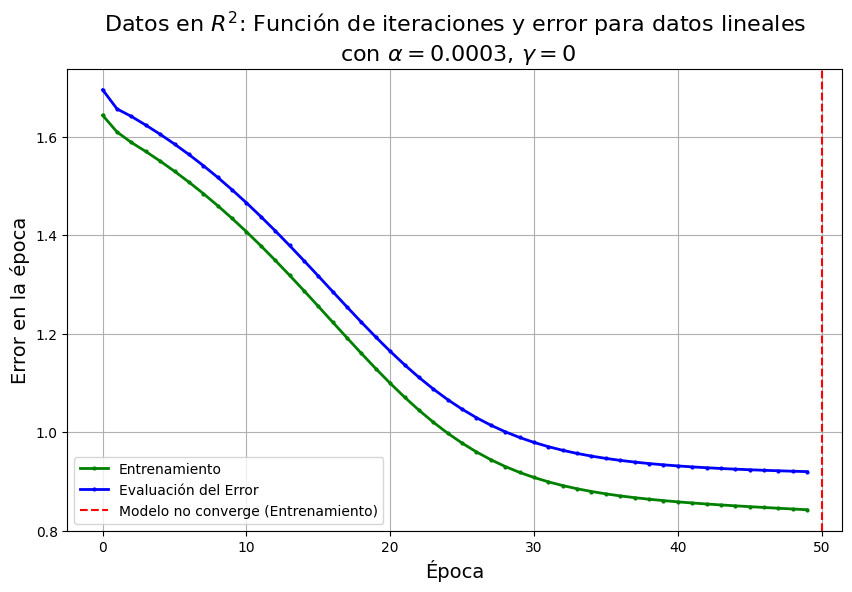

Epoch [1/50], Loss: 1.0361522436141968
Epoch [2/50], Loss: 1.0337570905685425
Epoch [3/50], Loss: 1.0318427085876465
Epoch [4/50], Loss: 1.0302990674972534
Epoch [5/50], Loss: 1.0290396213531494
Epoch [6/50], Loss: 1.027997374534607
Epoch [7/50], Loss: 1.0271204710006714
Epoch [8/50], Loss: 1.0263690948486328
Epoch [9/50], Loss: 1.0257132053375244
Epoch [10/50], Loss: 1.0251295566558838
Epoch [11/50], Loss: 1.024600625038147
Epoch [12/50], Loss: 1.024113416671753
Epoch [13/50], Loss: 1.0236579179763794
Epoch [14/50], Loss: 1.0232269763946533
Epoch [15/50], Loss: 1.0228146314620972
Epoch [16/50], Loss: 1.0224171876907349
Epoch [17/50], Loss: 1.022031545639038
Epoch [18/50], Loss: 1.0216554403305054
Epoch [19/50], Loss: 1.0212873220443726
Epoch [20/50], Loss: 1.0209261178970337
Epoch [21/50], Loss: 1.0205707550048828
Epoch [22/50], Loss: 1.0202213525772095
Epoch [23/50], Loss: 1.0198769569396973
Epoch [24/50], Loss: 1.0195379257202148
Epoch [25/50], Loss: 1.019203782081604
Epoch [26/50],

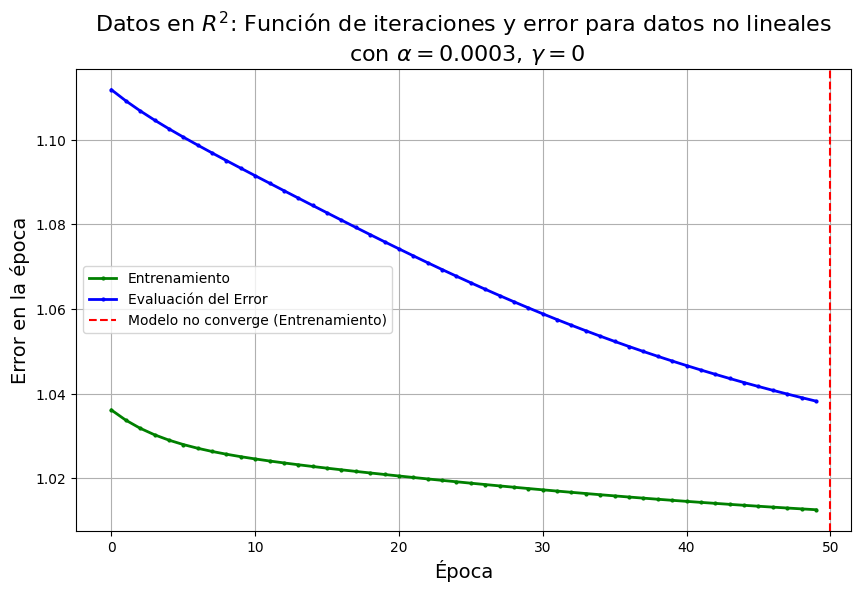

In [ ]:
from sklearn.model_selection import train_test_split

# Número de épocas a iterar
EPOCHS_R2 = 50

def train_and_validate(X, T, mlp, i, tipo):
    # Se usa el 80% para entrenar el modelo y el 20% para evaluarlo el modelo
    X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2, random_state=42, stratify=T)

    # Entrenamiento del modelo con los datos de entrenamiento
    errorsTrain, errorsTest, epoch_convergeTrain = trainR2(X_train, T_train, X_test, T_test, mlp)
    log_data(mlp, errorsTrain, epoch_convergeTrain, f'{tipo} iter {i}')

    # Graficar la curva de aprendizaje para el modelo con datos de entrenamiento
    graphic_errors(errorsTrain, errorsTest, epoch_convergeTrain, tipo, mlp)


# Entrenador para la clasificación de datos en R^2
def trainR2(X, T, X_test, T_test, mlp):
    # Ajustamos los targets para el modelo
    T = torch.where(T == 0, torch.tensor(-1.), T)
    T_test = torch.where(T_test == 0, torch.tensor(-1), T_test)

    # Train
    return mlp.train_mlp(EPOCHS_R2, X, T, alpha=mlp.alpha, gamma=mlp.gamma, X_test=X_test, T_test=T_test)


# Probar el modelo con datos linealmente separables
tipo1 = "lineales"
tipo2 = "no lineales"

classes_r2 = [
    [X1_r2, T1_r2, tipo1],
    [X2_r2, T2_r2, tipo2]
]

i = 0
for C in classes_r2:
    X_r2, T_r2, msg = C
    for mlp in neural_networks_r2:
        train_and_validate(X_r2, T_r2, mlp, i, msg)
        i+=1

# Clasificador de ataques usando datos estructurados
---

## Librerías necesarias

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## Carga de datos

In [ ]:
# Carga de los datos
df = pd.read_csv('/content/UNSW_NB15_training-set.csv')

# Elimina columnas no necesarias
list_drop = ['id','attack_cat']
df.drop(list_drop, axis=1,inplace = True)

# Descripción de datos categóricos
df.describe(exclude=np.number)

,proto,service,state
count,82332,82332,82332
unique,131,13,7
top,tcp,-,FIN
freq,43095,47153,39339


### Filtrar únicamente por datos categóricos
- Preserva sólo los registros con valores dentro de los 5 primeros valores más frecuentes (por defecto por pandas)
- Reemplaza con `"-"` si el valor no está entre los 5 más frecuentes


In [ ]:
# Filtrar solo pro datos categóricos
df_cat = df.select_dtypes(exclude=[np.number])

DEBUG = 1
for feature in df_cat.columns:
    top5 = df[feature].value_counts().head()
    if DEBUG == 1:
        print("Feature:", feature)
        print('nunique = '+str(df_cat[feature].nunique()))
        print("Is the cardinality higher than 6? ", df_cat[feature].nunique()>6)
        print("Number of preserved records: ", sum(df[feature].isin(top5.index)))
        print("New categories:", top5.index)
        print(2*'---------------------------------------------')

    if df_cat[feature].nunique() > 6:
        df[feature] = np.where(df[feature].isin(top5.index), df[feature], '-')

df.describe(exclude=np.number)

Feature: proto
nunique = 131
Is the cardinality higher than 6?  True
Number of preserved records:  77691
New categories: Index(['tcp', 'udp', 'unas', 'arp', 'ospf'], dtype='object', name='proto')
------------------------------------------------------------------------------------------
Feature: service
nunique = 13
Is the cardinality higher than 6?  True
Number of preserved records:  80210
New categories: Index(['-', 'dns', 'http', 'smtp', 'ftp'], dtype='object', name='service')
------------------------------------------------------------------------------------------
Feature: state
nunique = 7
Is the cardinality higher than 6?  True
Number of preserved records:  82330
New categories: Index(['FIN', 'INT', 'CON', 'REQ', 'ACC'], dtype='object', name='state')
------------------------------------------------------------------------------------------


,proto,service,state
count,82332,82332,82332
unique,6,5,6
top,tcp,-,FIN
freq,43095,49275,39339


### Codificación one-hot vector

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

feature_names = list(X.columns)
feature_indxs = [X.columns.get_loc(x) for x in df_cat.columns]

print("Number of features before one hot encoding:", len(feature_names))

# create the one hot encoder transformer and transform:
# columns 1, 2 and 3 are the ones to encode
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), feature_indxs)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

print("Number of features after one hot encoding:", X.shape)

Number of features before one hot encoding: 42
Number of features after one hot encoding: (82332, 56)


## Preparar datos para el entrenamiento

In [ ]:
def add_ones_column(input):
    ones_column = np.ones((input.shape[0], 1))
    return torch.tensor(np.hstack((ones_column, input)), dtype=torch.float)

def swap_zeros(input):
    input = torch.tensor(input.values, dtype=torch.float)
    input[input == 0] = -1
    return input.unsqueeze(1)

# Dividir los datos en conjuntos de entrenamiento y validación
# Se usa el 80% para entrenar el modelo y el 20% para evaluarlo el modelo
X_train, X_test, T_train, T_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

# Crear una columna de unos
X_train = add_ones_column(X_train)
X_test = add_ones_column(X_test)

# Cambiar 0 por -1
T_train = swap_zeros(T_train)
T_test = swap_zeros(T_test)

In [ ]:
print("T_train shape\n", T_train.shape, "\n")
print("T_test shape\n", T_test.shape)

T_train shape
 torch.Size([65865, 1]) 

T_test shape
 torch.Size([16467, 1])


## Entrenamiento con el MLP

### Gráficos de resultados

In [ ]:
def plot_structured_result(r2_model, errors_train, errors_test, epoch_converge, epochs, title=""):
    # Obtenemos el resultado (Y_s) y vemos si es un resultado cercano a las salidas esperadas
    predicted = torch.where(r2_model.Y_s > 0.9, torch.tensor(1.), torch.where(r2_model.Y_s < -0.9, torch.tensor(-1.), r2_model.Y_s))
    print("Salida del modelo r2 sin procesar\n", r2_model.Y_s)
    print("Salida del modelo r2 procesada\n", predicted)

    # Se imprime los parámetros usados, los errores y la época donde la red converge
    print(f"Configuración de hiperparámetros: alpha {r2_model.alpha}, gamma {r2_model.gamma}, épocas {epochs}")
    print("Errores train: ", errors_train)
    print("Errores test: ", errors_test)
    print("Red converge en ", epoch_converge)

    # Crear un gráfico para visualizar la curva de aprendizaje
    plt.figure(figsize=(10, 6))  # Tamaño del gráfico
    plt.plot(range(len(errors_train)), errors_train, color='blue', linewidth=1, marker='.', markersize=1.5, label="Entrenamiento")  # Graficar los errores de entrenamiento
    plt.plot(range(len(errors_test)), errors_test, color="green", linewidth=1, marker='.', markersize=1.5, label="Validación") # Graficar los errores de prueba
    plt.xlabel('Época')  # Etiqueta del eje x
    plt.ylabel('Error en la época')  # Etiqueta del eje y
    plt.title(title)  # Título del gráfico
     # Si la red converge, se coloca el punto en x de acorde
    if epoch_converge is not None:
        plt.axvline(x=epoch_converge, color='orange', linestyle='--', label=f'Convergencia en {epoch_converge} épocas (Entrenamiento)')
    else:
        plt.axvline(x=epochs, color='orange', linestyle='--', label=f'Red no converge para la configuración dada')
    plt.legend()
    plt.grid(True)  # Activar la cuadrícula
    plt.tight_layout()  # Ajustar el espacio de la figura
    #plt.savefig(f'{directory}curva_aprendizaje_alpha_{alpha}_gamma_{gamma}_epochs_{epochs}.png', dpi=300)
    plt.show()  # Mostrar el gráfico

### Función de entrenamiento

In [ ]:
def train_structured_data(epochs, X, T, X_test, T_test, params, print_e=True):
    M, alph, gamm = params

    # Neuronas para el modelo
    neurons = [X.shape[1], M, T.shape[1]]

    # Crear objeto de clase MLP con nueronas para el entrenamiento
    mlp = Multi_layer_perceptron(neurons_per_layer=neurons, max_weights=1)

    # Corregir matriz de pesos para ser de tipo double
    errors_train, errors_test, epoch_converge = mlp.train_mlp(epochs, X, T, alpha=alph, gamma=gamm, X_test=X_test, T_test=T_test, print_e=print_e)
    return mlp, errors_train, errors_test, epoch_converge

M:  17
Epoch [1/50], Loss: 1.2725543975830078
Epoch [2/50], Loss: 1.1885470151901245
Epoch [3/50], Loss: 1.1215189695358276
Epoch [4/50], Loss: 1.0733526945114136
Epoch [5/50], Loss: 1.0415523052215576
Epoch [6/50], Loss: 1.0217450857162476
Epoch [7/50], Loss: 1.0098092555999756
Epoch [8/50], Loss: 1.0027917623519897
Epoch [9/50], Loss: 0.9986909031867981
Epoch [10/50], Loss: 0.9962984323501587
Epoch [11/50], Loss: 0.9949040412902832
Epoch [12/50], Loss: 0.9940898418426514
Epoch [13/50], Loss: 0.9936134815216064
Epoch [14/50], Loss: 0.9933342933654785
Epoch [15/50], Loss: 0.9931704998016357
Epoch [16/50], Loss: 0.9930737018585205
Epoch [17/50], Loss: 0.9930170178413391
Epoch [18/50], Loss: 0.9929834604263306
Epoch [19/50], Loss: 0.9929637908935547
Epoch [20/50], Loss: 0.9929516911506653
Epoch [21/50], Loss: 0.9929449558258057
Epoch [22/50], Loss: 0.9929406642913818
Epoch [23/50], Loss: 0.9929380416870117
Epoch [24/50], Loss: 0.9929364919662476
Epoch [25/50], Loss: 0.9929355978965759
Ep

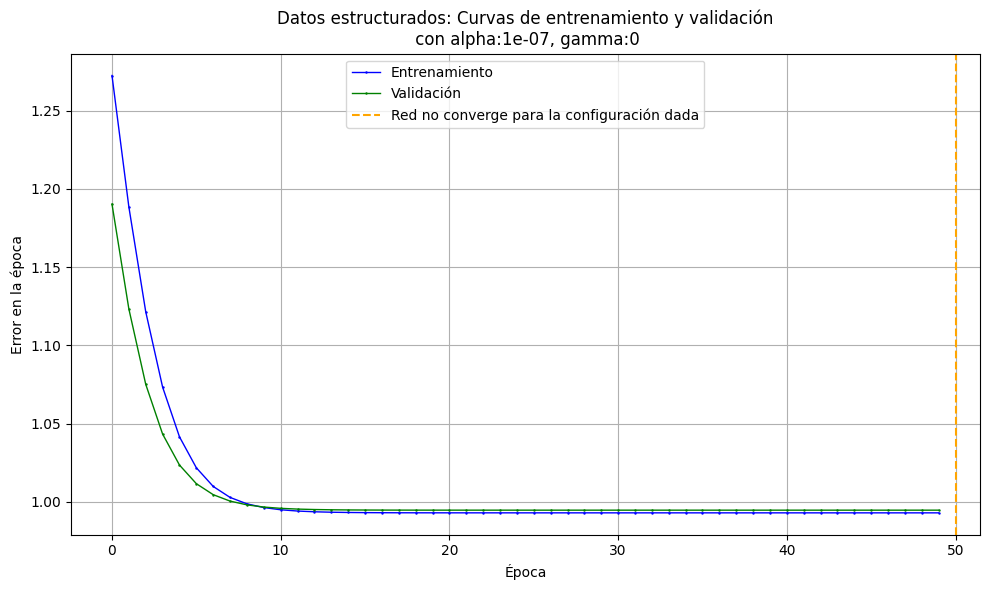

In [ ]:
M = 17 # número de neuronas en la capa oculta
print("M: ", M)
alph, gamm = 1e-7, 0
params = [M, alph, gamm]
train = train_structured_data(50, X_train, T_train, X_test, T_test, params)
title = f'Datos estructurados: Curvas de entrenamiento y validación\n con alpha:{train[0].alpha}, gamma:{train[0].gamma}'
plot_structured_result(train[0], train[1], train[2], train[3], 50, title)

## Optimización de Hiperparámetros con Optuna

In [ ]:
!pip install optuna
import optuna
import optuna.visualization as vis

In [ ]:
def objective(trial):
    # Generar candidatos de hiperparámetros con Optuna
    D = X_train.shape[1]
    M = trial.suggest_int('M', 1, 20)  # Número de neuronas en la capa oculta
    alpha = trial.suggest_float('alpha', 1e-10, 1e-1, log=True)
    # trial.suggest_float('gamma', 0., 0., log=True)
    gamm = 0

    params = [M, alpha, gamm]

    # Creamos y entrenamos el modelo con los parámetros seleccionados
    _, errors_train, errors_test, epoch_converge = train_structured_data(50, X_train, T_train, X_test, T_test, params, print_e=False)

    # Minimizamos el error de validación final
    return errors_train[-1]  # suponiendo que errors_test contiene el error de validación en cada época

# Definir el estudio de Optuna y número de trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Mejores parámetros encontrados
print("Best trial: ", study.best_trial.value)
print("Params: ")
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
M = study.best_trial.params["M"] # número de neuronas en la capa oculta
print("M: ", M)
alph, gamm = study.best_trial.params["alpha"], 0
params = [M, alph, gamm]
train = train_structured_data(50, X_train, T_train, X_test, T_test, params)

plot_structured_result(train[0], train[1], train[2], train[3], 50)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_param_importances(study)

# Pruebas con datos normalizados
----

Salida del modelo r2 sin procesar
 tensor([[0.1009],
        [0.1009],
        [0.1009],
        ...,
        [0.1009],
        [0.1009],
        [0.1009]])
Salida del modelo r2 procesada
 tensor([[0.1009],
        [0.1009],
        [0.1009],
        ...,
        [0.1009],
        [0.1009],
        [0.1009]])
Configuración de hiperparámetros: alpha 1.4025449652767838e-06, gamma 0, épocas 50
Errores train:  [1.2781457901000977, 1.1316604614257812, 1.028196930885315, 0.9951857328414917, 0.9905509948730469, 0.9901148080825806, 0.9900689721107483, 0.9900574684143066, 0.9900498390197754, 0.9900439381599426, 0.9900389313697815, 0.9900348782539368, 0.9900314807891846, 0.9900282025337219, 0.9900253415107727, 0.9900228977203369, 0.9900206923484802, 0.9900187849998474, 0.9900168776512146, 0.9900150895118713, 0.9900136590003967, 0.9900121092796326, 0.9900111556053162, 0.9900096654891968, 0.990008533000946, 0.9900075793266296, 0.9900065660476685, 0.9900056719779968, 0.9900047779083252, 0.990003824

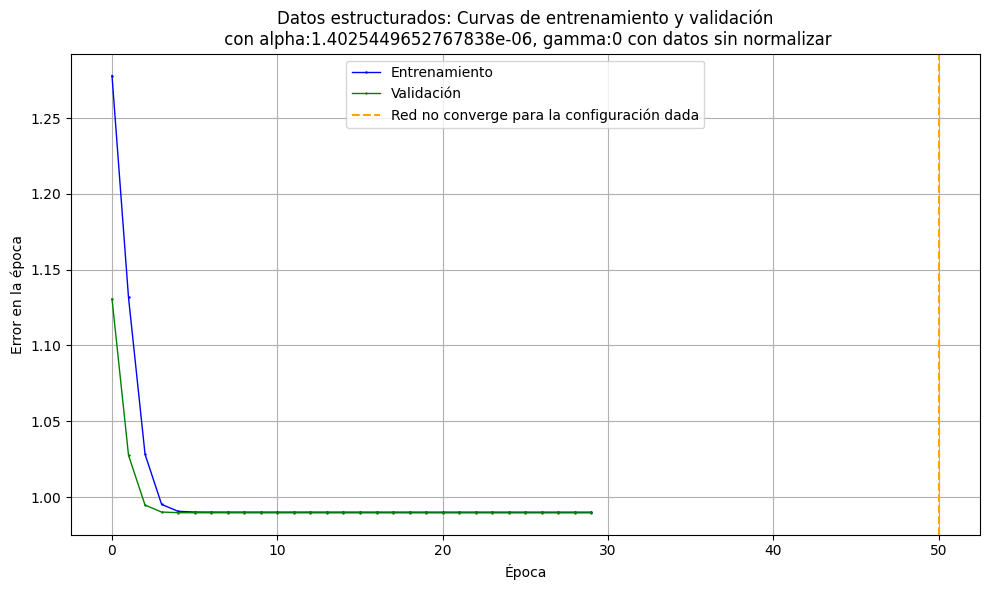

Salida del modelo r2 sin procesar
 tensor([[-0.2792],
        [-0.1992],
        [-0.2134],
        ...,
        [-0.2147],
        [ 0.5625],
        [-0.1701]])
Salida del modelo r2 procesada
 tensor([[-0.2792],
        [-0.1992],
        [-0.2134],
        ...,
        [-0.2147],
        [ 0.5625],
        [-0.1701]])
Configuración de hiperparámetros: alpha 1.4025449652767838e-06, gamma 0, épocas 50
Errores train:  [1.4072166681289673, 1.3148847818374634, 1.2277277708053589, 1.1529675722122192, 1.0931015014648438, 1.0466313362121582, 1.0107123851776123, 0.9827374219894409, 0.9607351422309875, 0.9432724714279175, 0.9292994737625122, 0.91802978515625, 0.9088661670684814, 0.9013538956642151, 0.8951413035392761, 0.8899560570716858, 0.8855865597724915, 0.8818689584732056, 0.8786736726760864, 0.8758987784385681, 0.8734639286994934, 0.8713043928146362, 0.8693694472312927, 0.8676174879074097, 0.8660146594047546, 0.8645340204238892, 0.8631526827812195, 0.8618525266647339, 0.8606178164482117,

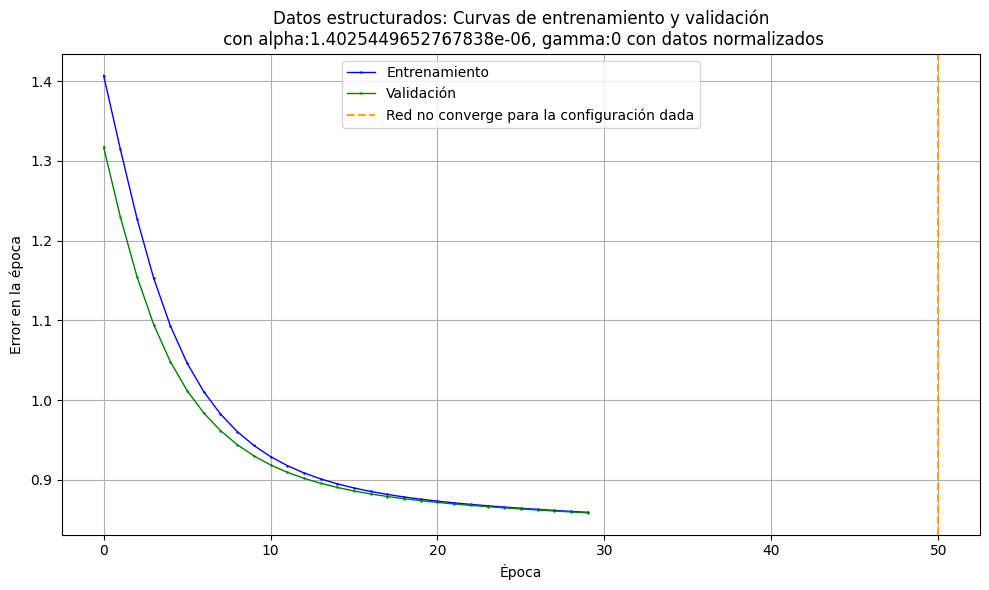

In [ ]:
def normalize_data(X):
    """ Normaliza los datos de entrada entre 0 y 1 usando la normalización ℓ∞. """
    # Asegura que X es un tensor de PyTorch
    X = torch.as_tensor(X, dtype=torch.float32)

    # Calcula el valor máximo por observación (a lo largo de cada fila si X es una matriz 2D)
    X_max = X.abs().max(dim=1, keepdim=True)[0]

    # Evita la división por cero ajustando los valores máximos que sean cero a uno
    X_max[X_max == 0] = 1

    # Normaliza los datos
    return X / X_max

data = {
    "Trial": [],
    "min(training)": [],
    "min(testing)": [],
}

data_norm = {
    "Trial": [],
    "min(training)": [],
    "min(testing)": [],
}

P = 30

# Normalizar los datos de entrenamiento y prueba
X_train_norm = normalize_data(X_train)
X_test_norm = normalize_data(X_test)

M = study.best_trial.params["M"] # número de neuronas en la capa oculta
alph, gamm = study.best_trial.params["alpha"], 0
params = [M, alph, gamm]

train = train_structured_data(P, X_train, T_train, X_test, T_test, params, print_e=False)
train_norm = train_structured_data(P, X_train_norm, T_train, X_test_norm, T_test, params, print_e=False)

title = f'Datos estructurados: Curvas de entrenamiento y validación\n con alpha:{train[0].alpha}, gamma:{train[0].gamma} con datos sin normalizar'
title_nomr = f'Datos estructurados: Curvas de entrenamiento y validación\n con alpha:{train_norm[0].alpha}, gamma:{train_norm[0].gamma} con datos normalizados'


data["Trial"].append(_+1)
data["min(training)"].append(min(train[1]))
data["min(testing)"].append(min(train[2]))

data_norm["Trial"].append(_+1)
data_norm["min(training)"].append(min(train_norm[1]))
data_norm["min(testing)"].append(min(train_norm[2]))

plot_structured_result(train[0], train[1], train[2], train[3], 50, title)
plot_structured_result(train_norm[0], train_norm[1], train_norm[2], train_norm[3], 50,title_nomr)

In [ ]:
bdf = pd.DataFrame(data)
ndf = pd.DataFrame(data_norm)

In [ ]:
bdf.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n & Trial & min(training) & min(testing) \\\\\n\\midrule\n0 & 30 & 0.990004 & 0.989558 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
ndf.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n & Trial & min(training) & min(testing) \\\\\n\\midrule\n0 & 30 & 0.859436 & 0.858770 \\\\\n\\bottomrule\n\\end{tabular}\n'